In [1]:
gasdensity(p) = 1.2p / 101325 # at 25 degrees C.
electricfield(V, d) = V / d
resistance(r, d, ∫i²) = 876.0d * r^(2/5) / ∫i²^(3/5) # Vlastos
inductance(r, d) = 2.0d * (log(2d / r) - .75) * 1e-9 # Wire Inductance

Braginskii(ρ, i, t) = 9.3e-4 * i^(1/3) * t^(1/2) * ρ^(1/6)
THMartin(E, ρ) = 98700 * (E / ρ + 1e-15) ^ (-3.44) / ρ
Bruce(p, d) = (24.55 * (p / 760)^(1.0) * (1e2d)^(1.0) +
                6.66 * (p / 760)^(0.5) * (1e2d)^(0.5)) * 1000

# ρ in [kg/m3], i in [A], t in [s], result in [m]
Braginskii_SI(ρ, i, t) = 9.3e-4 * (1e-3*i)^(1/3) * (1e6*t)^(1/2) * (1e-3*ρ)^(1/6)   # channel radius

# E in [V/m], ρ in [kg/m3], result in [s]
THMartin_SI(E, ρ) = 98700 * ((1e-5*E) / (1e-3*ρ)) ^ (-3.44) / (1e-3*ρ)              # breakdown delay

# p in [Pa], d in [m], result in [V]
Bruce_SI(p, d) = (24.55 * (p / 101325)       * (1e2*d) + 
                  6.66  * (p / 101325)^(0.5) * (1e2*d)^(0.5)) * 1000                # breakdown voltage

# r in [m], d in [m], result in [H] 
Grover_SI(r, d) = 200.0d * (log(200d / r) - .75) * 1e-9                             # arc (wire) inductance

# r in [m], d in [m], i in [A], result in [Ω]
Vlastos_SI(r, d, ∫i²) = 876.0d * r^(2/5) / ∫i²^(3/5)                                # arc resistance
nothing

In [2]:
using StaticArrays
using ACME


Δt = 5e-9

params = Dict{String, Any}(
    "pressure" => 101325,
    "distance" => 0.001,
    "t_arc" => 0.0,
    "t_over" => 0.0,
    "∫i²" => 0.0,
    "Δt" => Δt,
    "v_break" => Bruce_SI(101325, 0.001),
    "i_min" => 5e-5,
    "channel_on" => false
    )


nonlinear_eq = @inline function(q, params)
    v, i, Φ, u = q
    if params["channel_on"] == false
        j = @SVector [(v - u), (i)]
        J = @SMatrix [(1) (0.) (.0) (-1);
                      (0) (1.) (.0) (.0)] 
    else
        if i ≈ 0.0 i = 1e-12 end
        i = abs(i)
        ch_rad = Braginskii_SI(gasdensity(params["pressure"]), i, params["t_arc"])
        Ri  = Vlastos_SI(ch_rad, params["distance"], params["∫i²"] + (i^2) * params["Δt"]) * i
        dRi = -14.2497 * params["distance"] *
            (i^(1/3)* gasdensity(params["pressure"])^(1/6) * params["t_arc"]^(1/2)) /
                (i^2 * params["t_arc"])^(3/5)

        Li  = Grover_SI(ch_rad, params["distance"])*i
        dLi = 2.0e-7 * params["distance"] *
            (log((215054. * params["distance"]) / 
                (i^(1/3)* gasdensity(params["pressure"])^(1/6) * params["t_arc"]^(1/2))) -
            1.08333) 

        j = @SVector [(Ri - u), (Li - Φ)]
        J = @SMatrix [(0) (dRi) (.0) (-1);
                      (0) (dLi) (-1) (.0)] 
    end
    return (j, J)
    end

afternewton = @inline function(q, params)
    v, i, Φ, u = q
    if params["channel_on"]
        if i > params["i_min"]
            params["t_arc"] += params["Δt"]
            params["∫i²"] += i^2 * params["Δt"]
        else
            params["channel_on"] = false
            params["∫i²"] = 0.0
            params["t_arc"] = 0.0
        end
    elseif v > params["v_break"]
        t_delay = THMartin_SI(electricfield(v,params["distance"]), gasdensity(params["pressure"]))
        params["t_over"] += params["Δt"]
        if params["t_over"] > t_delay
            params["channel_on"] = true
            params["∫i²"] = i^2 * params["Δt"]
            params["t_arc"] = params["Δt"]
            params["t_over"] = 0.0
        end
    end
end

arcchannel() =
  ACME.Element(mv=[1;1;0;0;0], mi=[0;0;1;0;0], mx=[0 -1;0 0;0 0;1 0;0 1], mxd=[-1 0;0 0;0 0;0 0;0 0],
        mq=[0 0 0 0;-1 0 0 0;0 -1 0 0; 0 0 -1 0; 0 0 0 -1], ports=[:1 => :2],
        nonlinear_eq = nonlinear_eq)

cir = @circuit begin
    i = currentprobe()
    v = voltagesource()
    R_Ch = resistor(1e6)
    C = capacitor(1e-9)
    R_L = resistor(150)
    ⚡ = arcchannel()
end

connect!(cir, (:v, +), (:R_Ch, 1))
connect!(cir, (:v, -), (:C, 1), (:R_L, 2), :gnd)
connect!(cir, (:R_Ch, 2), (:C, 2))
connect!(cir, (:C, 2), (:i, -))
connect!(cir, (:i, +), (:⚡, 1))
connect!(cir, (:R_L, 1), (:⚡, 2))

In [3]:
include("automatic-differentiation.jl")

(0.0) + [1.0ϵ]

In [4]:
#import Pkg; Pkg.add("ProgressMeter")
using ProgressMeter; 
ProgressMeter.ijulia_behavior(:clear)

include("circuit-model.jl")

A, B, C, Di, Ei, Fi, Dv, Ev, Fv, Dq, Eq, Fq = matrices(cir, Δt, 1)
x̄, y, ū, q̄, z = states(B, C, Di, Dq, T=Dual{Float64})
dmodel = DifferentiableModel(A, B, C, Di, Ei, Fi, Dq, Eq, Fq,
    x̄, y, ū, q̄, z, params)

t = 0:Δt:3.5e-3

const progress = Progress(length(t))

u = similar(t)
y = similar(u)
dy = similar(u)

for i=1:length(t)
    u[i] = 10e3
    step!(dmodel, u[i,:,:] .+ ϵ, nonlinear_eq)
    afternewton(dmodel.q̄, dmodel.params)
    y[i] = value(dmodel.y[1])
    dy[i] = partials(dmodel.y[1])
    update!(progress, i; showvalues=[(:iteration, i),(:timesteps, length(t))]) # progressbar
end
println("Finished!")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31
  iteration:  700001
  timesteps:  700001


Finished!


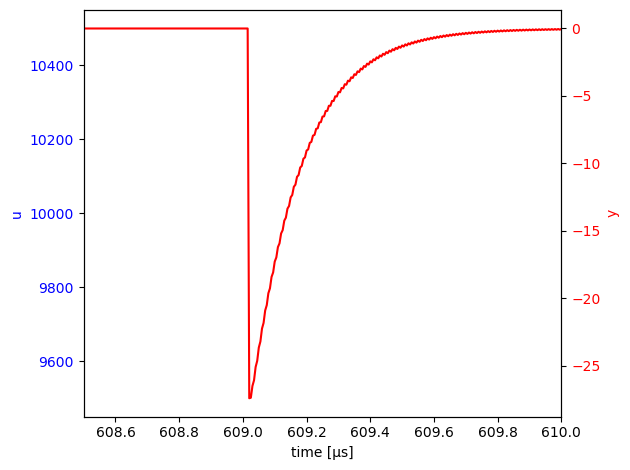

In [5]:
using PyPlot
fig, yleft = subplots()
yright = yleft.twinx()

yleft.set_ylabel("u", color="blue")
yleft.tick_params(axis="y", labelcolor="blue")
yleft.plot(t, u, color="blue")

yright.set_ylabel("y", color="red")
yright.tick_params(axis="y", labelcolor="red")
yright.plot(1e6t, y, color="red")
xlim([608.5, 610])
yleft.set_xlabel("time [μs]")
fig.tight_layout()  # otherwise the right y-label is slightly clipped

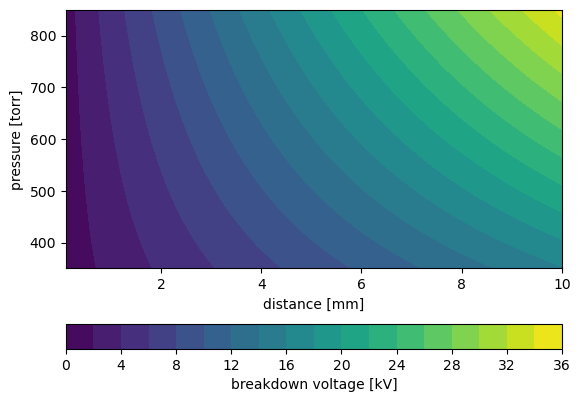

In [6]:
Vbreak = [Bruce(p, d) for p in 350:850, d in 0.0001:0.0001:0.01]
contourf(0.1:0.1:10, 350:850, 1e-3Vbreak; levels=20)
xlabel("distance [mm]")
ylabel("pressure [torr]")
colorbar(location="bottom").set_label("breakdown voltage [kV]");

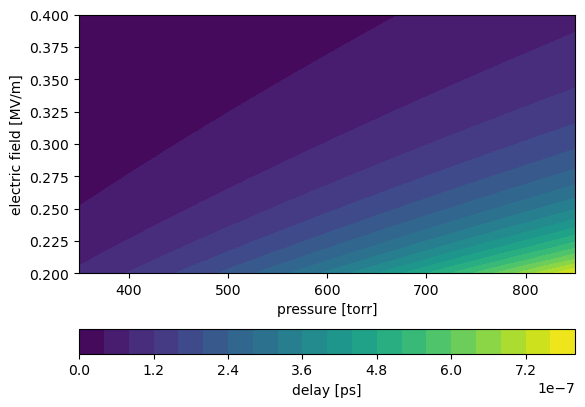

In [7]:
tdelay = [THMartin(E, gasdensity(p)) for E in 0.2e6:0.01e6:0.4e6, p in 350:850]
contourf(350:850, 0.2:0.01:0.4, 1e12tdelay; levels=20)
xlabel("pressure [torr]")
ylabel("electric field [MV/m]")
colorbar(location="bottom").set_label("delay [ps]");

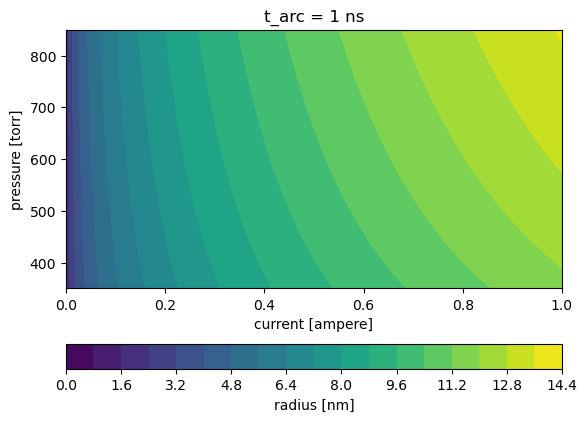

In [8]:
radius = [Braginskii(gasdensity(p), i, 1e-9) for p in 350:850, i in 0.0:2e-3:1.0]
contourf(0.0:2e-3:1.0, 350:850, 1e9radius; levels=20)
xlabel("current [ampere]")
ylabel("pressure [torr]")
title("t_arc = 1 ns")
colorbar(location="bottom").set_label("radius [nm]");

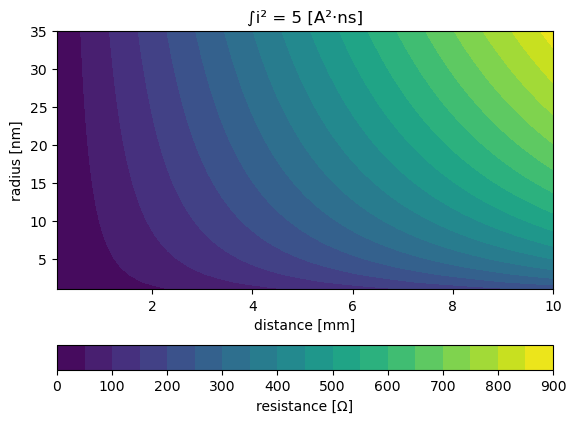

In [9]:
Rch = [resistance(r, d, 5e-9) for r in 1e-9:1e-9:35e-9, d in 0.0001:0.0001:0.01]
contourf(0.1:0.1:10, 1:35, Rch; levels=20)
xlabel("distance [mm]")
ylabel("radius [nm]")
title("∫i² = 5 [A²⋅ns]")
colorbar(location="bottom").set_label("resistance [Ω]");

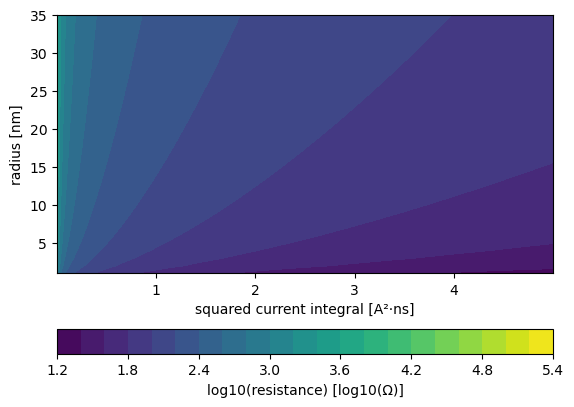

In [10]:
Rch = [resistance(r, 0.001, i²) for r in 1e-9:1e-9:35e-9, i² in 0.01e-12:1e-12:5e-9]
contourf(0.01e-3:1e-3:5, 1:35, log10.(Rch); levels=20)
xlabel("squared current integral [A²⋅ns]")
ylabel("radius [nm]")
colorbar(location="bottom").set_label("log10(resistance) [log10(Ω)]");

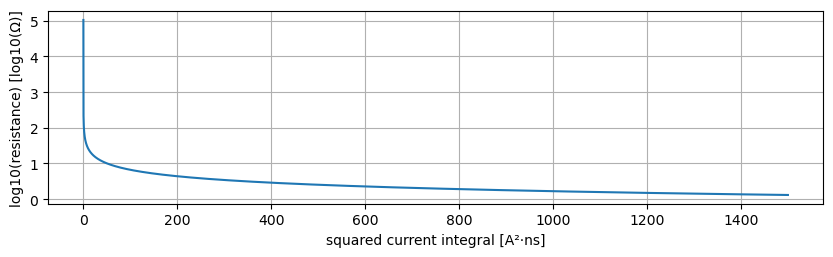

In [11]:
Rch = [resistance(5e-9, 0.001, i²) for i² in 0.01e-12:100e-12:1500e-9]
figure(figsize=(10, 2.5))
plot(0.01e-3:100e-3:1500, log10.(Rch))
xlabel("squared current integral [A²⋅ns]")
ylabel("log10(resistance) [log10(Ω)]")
grid();

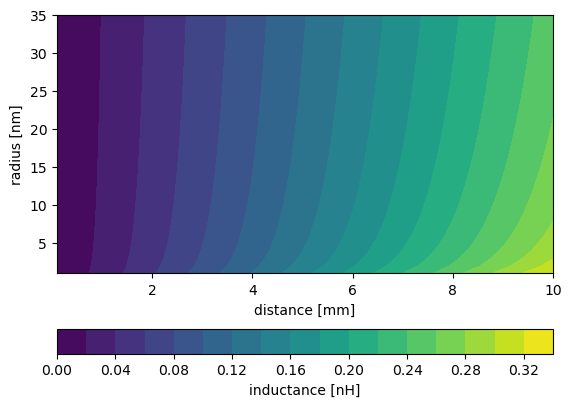

In [12]:
Lch = [inductance(r, d) for r in 1e-9:1e-9:35e-9, d in 0.0001:0.0001:0.01]
contourf(0.1:0.1:10, 1:35, 1e9Lch; levels=20)
xlabel("distance [mm]")
ylabel("radius [nm]")
colorbar(location="bottom").set_label("inductance [nH]");